

Laboratorio 3 - Modelo de Regresión Lineal

By Cristian Laynez - 201281

Se provee un dataset donde se muestran los precios de casas en King Country, Seattle. 
Este conjunto incluye los precios de las casas vendidas entre mayo 2014 y mayo 2015. 

El objetivo de este laboratorio es definir un modelo de regresion lineal donde se puedad verla relacion entre precio y pies cuadrasa del espacio habitable interior de los apartementos.

Task 1.1 - Leer csv proporcionado

In [6]:
# Importar todas las librerias a utilizar
import numpy as np
import matplotlib.pyplot as plt
import csv

In [7]:
# --> Leer la data proporcionada
f = open('kc_house_data.csv', 'r')
reader = csv.reader(f)
header = next(reader, None)

# Se guardara la data en un diccionario
data = {}
for h in header:
    data[h] = []

# Se guardaran todos los valores
for row in reader:
    control = 0
    for h, v in zip(header, row):        
        d = float(v) if control >= 2 else v
        temp = [d]
        data[h].append(temp)
        control += 1


In [24]:
# Imprimir todos los headers que se encontraron
print(header)

['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15']


Task 1.2 - Ajustar un modelo polinomial (regresion lineal)

In [9]:
# Definir funcion lambda de costo
cost = lambda X, y, t : ((X @ t - y) ** 2).sum() / len(y)

# Definir funcion lambda de gradiente
grad = lambda X, y, t : 2 * X.T @ (X @ t - y) / len(y)

# Definir funcion lambda de normalizacion que nos ayudara a tener un sistema de regresion lineal mas optimo
norm = lambda v : np.sqrt((v ** 2).sum())

# ! Referencia y creditos al ejemplo proveido en clase :)

In [10]:
# --> Ajustando sistema de regresion lineal
def linear_regression(X, y ,t, cost, grad, a=0.1, n=100, on_step=None):
    costs = []
    for _ in range(n):
        nabla = grad(X, y, t)
        t -= a * nabla
        costs.append(norm(nabla))

        if on_step:
            on_step(t)

    return t, costs

# ! Referencia y creditos al ejemplo proveido en clase :)

In [11]:
DATASET_SET_SIZE = len(data['id'])
DATASET_SPARSE_RATIO = 50
DATASET_X_LIM = 12000

[[221900.   1180.]
 [538000.   2570.]
 [180000.    770.]
 ...
 [402101.   1020.]
 [400000.   1600.]
 [325000.   1020.]]


Task 1.3 - Implementación vectorial del algoritmo de regresión lineal

In [12]:
# --> Obtener datos para mostrar la siguiente relacion:
# * precio y pies cuadrados del espacio habitable interior (price - sqft_living).
array_living = np.array(data['sqft_living'])
array_price = np.array(data['price'])
X = array_price.reshape((DATASET_SET_SIZE, 1))
Xr = np.hstack((
    np.ones((DATASET_SET_SIZE, 1)),
    array_living.reshape((DATASET_SET_SIZE, 1))
))
y = 3 + 2 * X + array_living.reshape((DATASET_SET_SIZE, 1)) * DATASET_SPARSE_RATIO

to = np.random.rand(Xr.shape[1], 1)
xmr = np.hstack((np.ones((X.shape[0], 1)), X))
theta = np.linalg.inv(xmr.T @ xmr) @ xmr.T @ array_price # array_living = y

# -> Utilizar la implementacion vectorial del algoritmo de regresion lineal
tf, costs = linear_regression(
    Xr, 
    y, 
    theta, 
    cost, 
    grad, 
    a=0.00000001, 
    n=1000,
)

print(f"Tf: {tf}")

# Preparar las variables para la prediccion
xm = np.array([[0], [DATASET_X_LIM]])
print(f"xm: {xm}")
xmr = np.hstack((
    np.ones((2, 1)),
    xm
))
ym = xmr @ tf
print(f"xmr: {xmr}")
print(f"ym: {ym}")

Tf: [[-5.30111404e-02]
 [ 5.76179606e+02]]
xm: [[    0]
 [12000]]
xmr: [[1.0e+00 0.0e+00]
 [1.0e+00 1.2e+04]]
ym: [[-5.30111404e-02]
 [ 6.91415522e+06]]


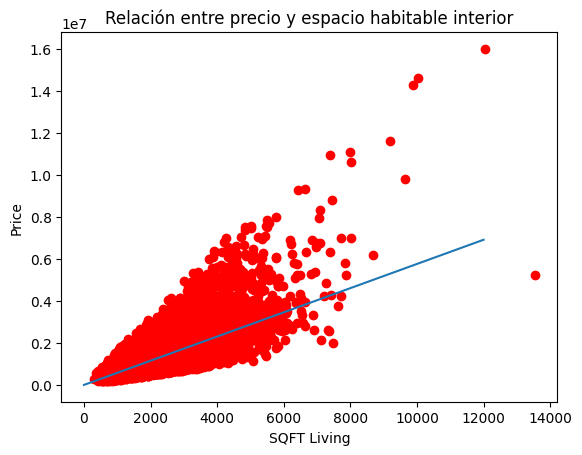

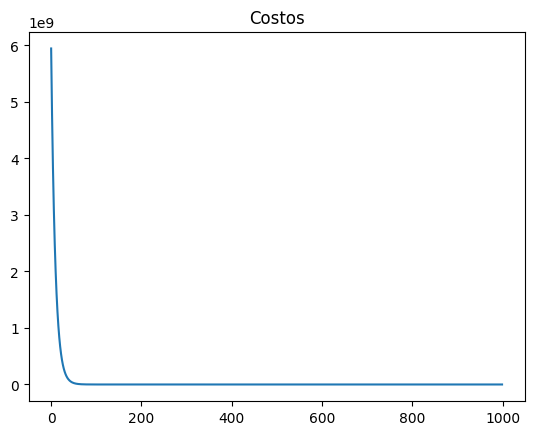

In [13]:
# Se graficara el resultado del modelo de regresion lineal

# ! Graficar modelo de regresion lineal
plt.plot(Xr[:, 1], y, 'ro') # datos
plt.plot(xm, ym) # regresion lineal
plt.title("Relación entre precio y espacio habitable interior")
# price - sqft_living
plt.xlabel('SQFT Living')
plt.ylabel('Price')
plt.show()

# ! Graficar costos
# Para visualizar que tan bueno es nuestro modelo de regresion lineal
plt.plot(costs)
plt.title("Costos")
plt.show()

Task 1.4 - Usar cross-validation para determinar el grado del polinomio

In [51]:
# Dividir los datos entre datos de entrenamiento y prueba
def data_sets_of_train_and_test(data, test_size=0.3):
    n = len(data)
    n_test = int(n * test_size)
    np.random.shuffle(data)
    data_train = data[n_test:]
    data_test = data[:n_test]
    return data_train, data_test

# Calcular el error cuadrático medio (MSE)
def mean_squared_error(X, y, degree):
    n = len(X)
    X_poly = np.column_stack([np.power(X, d) for d in range(1, degree+1)])
    X_poly = np.insert(X_poly, 0, 1, axis=1)
    theta = np.linalg.inv(X_poly.T.dot(X_poly)).dot(X_poly.T).dot(y)
    y_pred = X_poly.dot(theta)
    mse = np.sum(np.power(y_pred - y, 2)) / n
    return mse

# Cross-validation obtener error del modelo
def mse_cross_validation(data, degree, k=3):
    n = len(data)
    np.random.shuffle(data)
    mse = 0.0
    for i in range(k):
        test_indexes = np.arange(i, n, k)
        train_indexes = np.setdiff1d(np.arange(n), test_indexes)
        X_train = data[train_indexes][:, 0]
        y_train = data[train_indexes][:, 1]
        mse += mean_squared_error(X_train, y_train, degree)
    mse /= k
    return mse

# Determinar el mejor grado de polinomio con la dataset que se provea
def get_best_degree(data_set, min, max):
    degrees = list(range(min, max)) # Definir grado de grados
    best_degree = None
    best_mse = float('inf')
    for degree in degrees:
        mse = mse_cross_validation(data_set, degree)
        if mse < best_mse:
            best_mse = mse
            best_degree = degree
    return best_degree


In [53]:
# Preparar una matriz para probar y entrenar la data de price and sqft_living
data_for_test_and_train = [[data['price'][i][0], data['sqft_living'][i][0]] for i in range(DATASET_SET_SIZE)]
data_for_test_and_train = np.array(data_for_test_and_train)

# Obtener la data de prueba y entrenamiento
data_train, data_test = data_sets_of_train_and_test(data_for_test_and_train, test_size=0.3)

# Vamos a obtener el mejor grado de polinomio
print(f"El grado del polinomio para el entrenamiento es: {get_best_degree(data_train, 1, 25)}")

El grado del polinomio del entrenamiento es: 10


Task 1.5 - Análisis sobre los hallazgos

Como se podra observar en la grárfica de "Relación entre precio y espacio habitable interior" se puede apreciar una dispersión entre precio y espacio habitable.

Donde se puede ver que mientras mas se extiende price and sqft living existe mas dispersion donde ambos suelen ir en aumento.

La regresion lineal nos demuestra que si estan muy relacionados estas cualidades.

Afortunadamente se pudo encontrar un buen modelo de regresión lineal donde quedó demostrado en la gráfica de costos. Y por ultimo se pudo encontrar un buen balance con el grado de polinomio (cuyo resultado termino siendo 10), no es muy bajo ni demasiado alto.